# Data Import and Cleaning

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ignore SettingWithCopyWarning and FutureWarning
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import data from electronic bins
import os
import glob

columns = ['trans', 'cow', 'bin', 'timein', 'timeout', 'sec', 'kgin', 'kgout', 'kg']
globbed_files = glob.glob('bins0913/*.DAT')
data = []
for dat in globbed_files:
    frame = pd.read_csv(dat, sep=',', header=None, names = columns)
    frame['date'] = os.path.basename(dat) # filename contains date
    frame['date'] = frame['date'].replace({'VW': '', '.DAT': ''}, regex=True) # separate out date from filename
    frame['timein'] = frame['timein'].replace({' ': '0'}, regex=True) # add zero padding to hours
    frame['timeout'] = frame['timeout'].replace({' ': '0'}, regex=True) # add zero padding to hours
    frame['date'] = pd.to_datetime(frame['date']) # convert date and time into correct formats
    frame['timein'] = pd.to_timedelta(frame['timein'])
    frame['timeout'] = pd.to_timedelta(frame['timeout'])
    frame['dt_in'] = frame['date'] + frame['timein']
    frame['dt_out'] = frame['date'] + frame['timeout']
    data.append(frame)

bins = pd.concat(data, ignore_index=True)
bins.head()

,trans,cow,bin,timein,timeout,sec,kgin,kgout,kg,date,dt_in,dt_out
0,0,0,6,00:03:14,00:03:24,10,42.0,42.0,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
1,0,0,5,00:03:14,00:03:24,10,40.7,40.7,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
2,0,0,7,00:03:14,00:03:24,10,36.6,36.6,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
3,0,0,8,00:03:14,00:03:24,10,38.1,38.1,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24
4,0,0,9,00:03:14,00:03:24,10,26.3,26.3,0.0,2013-09-11,2013-09-11 00:03:14,2013-09-11 00:03:24


In [3]:
# sort data by bin and datetime 
bins.sort_values(by = ['bin','dt_in'], inplace = True)

# drop calibration data and data from bins not in study
indexNames = bins[(bins['trans'] == 0) | (bins['sec'] == 0) | (bins['cow'] == 0) | (bins['bin'] > 2)].index
bins.drop(indexNames, axis = 0, inplace = True)

# shift timeout down one cell to get interval between consecutive visits at 1 bin
bins['timelag'] = bins['dt_out'].shift(periods = 1)

# calcualte interval between consecutive visits at 1 bin
bins['intervalA'] = bins['dt_in'] - bins['timelag']

#shift intervalA up 1 cell to get intervalR
bins['intervalR'] = bins['intervalA'].shift(-1)

#only need dates 2013-09-12 to 2013-09-15
bins = bins[(bins['date'] > '2013-09-11') &(bins['date'] < '2013-09-16')]

bins.reset_index(drop=True, inplace=True)

#only keep columns needed
bins = bins[['date','cow','bin','timein', 'timeout','intervalR']]

#convert intervalR into seconds
bins['intervalR'] = (bins['intervalR'] / np.timedelta64(1, 's')).astype(int)
bins.head()

,date,cow,bin,timein,timeout,intervalR
0,2013-09-12,1100,1,00:06:10,00:06:40,25
1,2013-09-12,5103,1,00:07:05,00:07:58,160
2,2013-09-12,9029,1,00:10:38,00:10:45,54
3,2013-09-12,1097,1,00:11:39,00:11:56,105
4,2013-09-12,1038,1,00:13:41,00:15:29,88


In [4]:
# the processed electronically generated data is then exported to be paired with video scoring in excel
bins.to_csv('bins.csv')

In [5]:
# import data back with electronically generated data paired with video data
final = pd.read_csv('paired.csv')
final['date'] = pd.to_datetime(final['date'], dayfirst = True)
final.head()

,date,cow,intervalR,replace
0,2013-09-12,1100,25,0
1,2013-09-12,5103,160,0
2,2013-09-12,9029,54,0
3,2013-09-12,1097,105,0
4,2013-09-12,1038,88,0


In [6]:
#delete events where cow entered same bin again herself
final.drop(final[final['intervalR'] == '.'].index, inplace=True)

# Exploratory Data Analysis

In [7]:
# number of rows and columns
print('Number of rows:', final.shape[0])
print('Number of columns:', final.shape[-1])

Number of rows: 1414
Number of columns: 4


In [8]:
# what are the data types
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 0 to 1975
Data columns (total 4 columns):
date         1414 non-null datetime64[ns]
cow          1414 non-null int64
intervalR    1414 non-null object
replace      1414 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 55.2+ KB


In [9]:
# fix data types
final['intervalR']=final['intervalR'].astype(int)
final['cow']=final['cow'].astype('category')

In [10]:
# check that there are no missing values
np.mean(final.isna(), axis = 0)

date         0.0
cow          0.0
intervalR    0.0
replace      0.0
dtype: float64

In [11]:
# some descriptive statistics for interval and replace
final[['intervalR','replace']].describe()

,intervalR,replace
count,1414.00000,1414.000000
mean,362.06082,0.160537
std,706.90486,0.367234
min,9.00000,0.000000
25%,29.00000,0.000000
50%,101.00000,0.000000
75%,363.75000,0.000000
max,7336.00000,1.000000


In [12]:
# how many animals are there?
print('Number of animals:', final['cow'].nunique())

Number of animals: 20


In [13]:
# date range
print('Number of days:', final['date'].nunique())
print('Start date:', final['date'].min())
print('End date:', final['date'].max())

Number of days: 4
Start date: 2013-09-12 00:00:00
End date: 2013-09-15 00:00:00


In [14]:
# how many positive and negative replace events are there?
final['replace'].value_counts()

0    1187
1     227
Name: replace, dtype: int64

Finding: Negative events greatly outweigh positive events

In [15]:
# how many events occur on each day?
print('Total number of events:', final['replace'].sum())
final.groupby('date')['replace'].sum()

Total number of events: 227


date
2013-09-12    73
2013-09-13    42
2013-09-14    82
2013-09-15    30
Name: replace, dtype: int64

Text(0, 0.5, 'Total number of replacements')

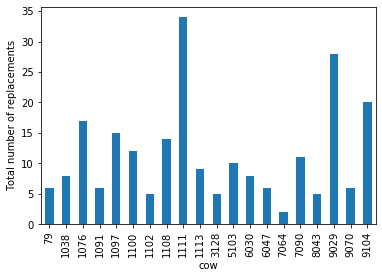

In [16]:
# how do events vary by animal?
final.groupby('cow')['replace'].sum().plot.bar()
plt.ylabel('Total number of replacements')

Finding: replace behaviour varies between animals

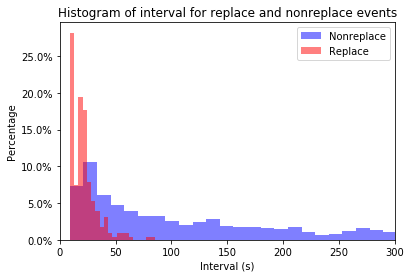

In [17]:
# histogram of replace events in training data
from matplotlib.ticker import PercentFormatter

replace = final[final['replace'] == 1]
nonreplace = final[final['replace'] == 0]

plt.hist(nonreplace['intervalR'], weights=np.ones(len(nonreplace)) / len(nonreplace), color='b',bins = 600, alpha = 0.5, label='Nonreplace')
plt.hist(replace['intervalR'], weights=np.ones(len(replace)) / len(replace), color='r', bins = 20,alpha = 0.5, label='Replace')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(0,300) # narrow in here to make it more interpretable
plt.xlabel('Interval (s)')
plt.ylabel('Percentage')
plt.title('Histogram of interval for replace and nonreplace events')
plt.legend()
plt.show()

Finding: postive replace events have shorter intervals

In [18]:
# descriptive statistics of positive and negative replace event for intervalR
final.groupby('replace')['intervalR'].describe()

,count,mean,std,min,25%,50%,75%,max
replace,,,,,,,,
0,1187.0,427.182814,754.249466,9.0,48.0,151.0,477.5,7336.0
1,227.0,21.533040,12.210633,9.0,12.0,20.0,25.5,85.0


# Logistic Regression and ROC Curve Analysis

In [19]:
# import libraries
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [20]:
# split into 2 days of training data and 2 days of test data
train = final[(final['date'] == '2013-09-13') | (final['date'] == '2013-09-14')]
test = final[(final['date'] == '2013-09-12') | (final['date'] == '2013-09-15')]

In [21]:
# split into X and y train and test
X_train = train[['intervalR']]
y_train = train['replace']
X_test = test[['intervalR']]
y_test = test['replace']

In [22]:
# check class counts
Counter(y_train)

Counter({0: 621, 1: 124})

In [23]:
# fix class imbalance with SMOTE (moreinfo = http://rikunert.com/SMOTE_explained)
sm = SMOTE(random_state=1)
X_bal, y_bal = sm.fit_resample(X_train, y_train)

In [24]:
# re-check class counts
Counter(y_bal)

Counter({0: 621, 1: 621})

In [25]:
# initiate and fit logistic regression model
model = LogisticRegression(random_state = 1) 
model.fit(X_bal, y_bal)
print('Training accuracy:', model.score(X_bal, y_bal))

Training accuracy: 0.8373590982286635


In [26]:
# look at confusion matrix of training set
y_pred = model.predict(X_bal)
tn, fp, fn, tp = confusion_matrix(y_bal, y_pred).ravel()
print('True negatives:', tn)
print('False positives:', fp)
print('False negatives:', fn)
print('True negative:', tn)

True negatives: 464
False positives: 157
False negatives: 45
True negative: 464


In [27]:
# get the classification report of training set
print(classification_report(y_bal, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       621
           1       0.79      0.93      0.85       621

    accuracy                           0.84      1242
   macro avg       0.85      0.84      0.84      1242
weighted avg       0.85      0.84      0.84      1242



Findings: For the training set - good accuracy of 84%, good precision of 80% (proportion of model assigned to positive that are actually members of the positive class), good recall of 93% (how many members of the positive class the model correctly identified out of the total), and good f1-score of 85% (harmonic average of precision and recall).

Let's visualize the model with a receiver operating characteristic curve

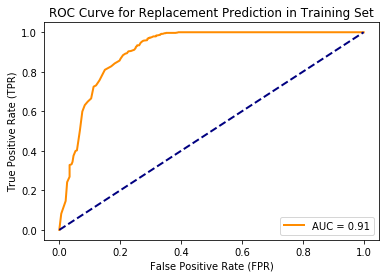

Area under curve (AUC):0.9081827399057674



In [28]:
# create ROC curve for training set
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_train = model.predict_proba(X_bal)[:,1]

fprs_train, tprs_train, thresholds_train = roc_curve(y_bal, y_proba_train)
roc_auc_train = roc_auc_score(y_bal, y_proba_train)

plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Replacement Prediction in Training Set')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc_train}')
print()

There are multiple ways to pick an optimal threshold. Because of the class imbalance (negative events are expected to always outweigh positive events), more importance should be placed on minimizing false positives than false negatives. A metric such as Youden's Index (sensitivity + specificty - 1) places equal weight on avoiding false positives and false negatives so will not be the best choice in this scenario. 

The optimal threshold will be chosen as the point where sensitivity roughly equals specificity.

In [29]:
# create dataframe of different thresholds and corresponding sensitivity and specificity
thres_sp_se_train = pd.DataFrame(np.vstack((thresholds_train,(1-fprs_train), tprs_train, ((1-fprs_train)-tprs_train)))).T.apply(pd.to_numeric)
thres_sp_se_train.columns=['threshold','sp','se', 'diff']
thres_sp_se_train['diff'] = abs(thres_sp_se_train['diff']) # get absolute value to find smallest difference
thres_sp_se_train = thres_sp_se_train.sort_values(by = 'diff').reset_index(drop=True)
thres_sp_se_train

,threshold,sp,se,diff
0,7.071603e-01,0.829308,0.827697,0.001610
1,7.202772e-01,0.840580,0.818035,0.022544
2,6.936899e-01,0.818035,0.842190,0.024155
3,7.330283e-01,0.850242,0.809984,0.040258
4,6.798804e-01,0.801932,0.856683,0.054750
...,...,...,...,...
155,8.971294e-01,0.993559,0.082126,0.911433
156,1.853774e-52,0.049919,1.000000,0.950081
157,2.375609e-53,0.046699,1.000000,0.953301
158,1.897129e+00,1.000000,0.000000,1.000000


In [30]:
# get value for optimal threshold where sensitivity roughly equals specificity
optimal_threshold = thres_sp_se_train.iat[0,0]
print('The probability threshold where sensitivity roughly equals sensitivity is:', optimal_threshold)

The probability threshold where sensitivity roughly equals sensitivity is: 0.7071603133696072


The optimal probability threshold is 71% (higher than the default threshold of 50%) in the training set.

Let's see how this threshold performs in the test set.

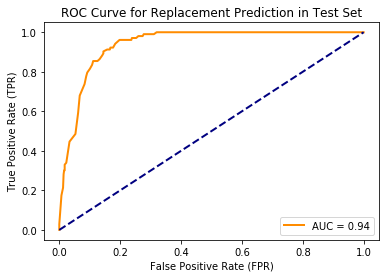

Area under curve (AUC):0.9377251363683146



In [31]:
# create ROC curve for test set
y_proba_test = model.predict_proba(X_test)[:,1]

fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

plt.figure()
plt.plot(fprs_test, tprs_test, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Replacement Prediction in Test Set')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc_test}')
print()

In [32]:
# get the sensitivity and specificity of the 70% probability threshold for the test set
thres_sp_se_test = pd.DataFrame(np.vstack((thresholds_test,(1-fprs_test), tprs_test, ((1-fprs_test)-tprs_test)))).T.apply(pd.to_numeric)
thres_sp_se_test.columns=['threshold','sp','se', 'diff']
thres_sp_se_test['diff'] = abs(thres_sp_se_test['diff']) # get absolute value to find smallest difference
thres_sp_se_test = thres_sp_se_test.sort_values(by = 'diff').reset_index(drop=True)
thres_sp_se_test.loc[thres_sp_se_test['threshold'] == optimal_threshold]

,threshold,sp,se,diff
3,0.70716,0.888693,0.854369,0.034324


The optimal probability threshold of 70% identified in the training set performs well on the test set with a specificty of 89% and a sensitivity of 85%